In [1]:
import numpy as np
from scipy import interpolate
import scipy.integrate as integrate
from astropy.cosmology import Planck15 as cosmo
import matplotlib.pyplot as plt
import scipy.constants as sc
from scipy import signal
from timeit import default_timer as timer

from scipy.interpolate import RectBivariateSpline

from astropy import units, cosmology


In [2]:
from ska_simulator.simulations import cosmological_signal
from ska_simulator import window_function
from ska_simulator import power_spectrum


%load_ext autoreload
%autoreload 2

- 151: 1.75

- 150 : 1.74

- 149: 1.728

- 148: 1.717


#  Define size of the simulated box 

In [17]:
# Simulation angular specs
ang_res = 16.*units.arcsec # angular resolution
#number of pixels in row and col (ang res)
npix = 200
#length and width of the box in Mpc
fov = ang_res.to(units.rad) * npix #rad

In [18]:
# Simulation spectral specs
nfreqs = 150
df = 100e3 * units.Hz
avg_nu = 150.e6 * units.Hz

spw_window = np.arange(avg_nu.value - df.value*nfreqs//2,
                       avg_nu.value + df.value*(nfreqs//2),
                       step=df.value) * units.Hz

print(f'{spw_window.size} frequency channels, '
      f'mean frequency {avg_nu.to(units.MHz):.1f}.')

150 frequency channels, mean frequency 150.0 MHz.


In [19]:
np.diff(spw_window.to('MHz'))



<Quantity [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
           0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
           0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
           0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
           0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
           0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
           0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
           0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
           0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
           0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
           0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
           0.1, 0.1, 0.1, 0.1, 0.1, 0.1] MHz>

# Define a True Pspec

In [6]:
 
def gaussian_ps(k, mu = 0.5, sigma = 0.1, amp = 10e-1):
    """
        Generate a Gaussian power spectrum of amplitude amp.

        Parameters
        ----------
                k: float or array of flats
                Fourier mode in Mpc-1.
                mu: float
                Mean of the Gaussian distribution
                sigma:float
                Standard deviation of the Gaussian distribution
                amp: float
                Desired amplitude for the PS, in K2.

        """


    return  amp*np.exp( - (k - mu)**2 / (2 * sigma**2))



def flat_ps(k, amp=10e-1):
        """
        Generate a flat power spectrum of amplitude amp.

        Parameters
        ----------
                k: float or array of flats
                Fourier mode in Mpc-1.
                amp: float
                Desired amplitude for the PS, in K2.

        """
        k = np.atleast_1d(k)
        return amp * np.ones(k.shape)

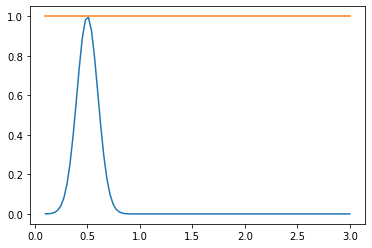

In [7]:
k = np.linspace(0.1,3,100)
plt.plot(k,gaussian_ps(k))
plt.plot(k,flat_ps(k))


# Generate Box

In [9]:
universe = cosmological_signal(
    ps=flat_ps,
    freqs=spw_window,
    npix=npix,
    ang_res=ang_res,
    verbose=True,
)


box = universe.make_universe()

Taking iFFT of box
Mean of simulated box = -4.441e-18


In [10]:
universe.Lz, universe.L

(5.151922913641052, 14.373145042074594)

Text(0.5, 1.0, '$z=8.47$')

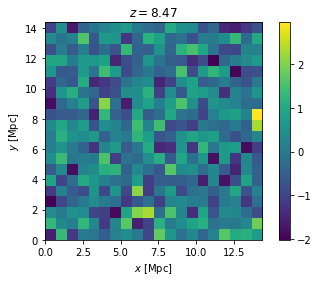

In [11]:
plt.figure()
plt.imshow(box[:, :, universe.nfreqs//2],
           origin='lower',
           extent=(0, universe.L, 0, universe.L))
plt.colorbar()
plt.xlabel(r'$x$ [Mpc]')
plt.ylabel(r'$y$ [Mpc]')
plt.title(fr'$z={universe.avg_z:.2f}$')

In [14]:
pspec_true = power_spectrum.power_spectrum(data = box * units.mK, 
                                          theta_x = fov, 
                                          theta_y= fov , 
                                          freqs =spw_window)

k_par, k_perp, ps_2D_true = pspec_true.compute_2D_pspec()
k, ps_1D_true = pspec_true.compute_1D_pspec()
k_from_2d, ps_from_2d_true = pspec_true.compute_1d_from_2d()

AssertionError: arr must be sorted in increasing order.

In [16]:
pspec_true.cosmo_volume, (universe.L*universe.L*universe.Lz)#, window.Lx*window.Ly*window.Lz

(1064.3215022480592, 1064.3218362968069)

In [15]:
(pspec_true.dRpara_dnu*pspec_true.freq_npix*pspec_true.delta_freq), universe.Lz,window.Lz

NameError: name 'window' is not defined

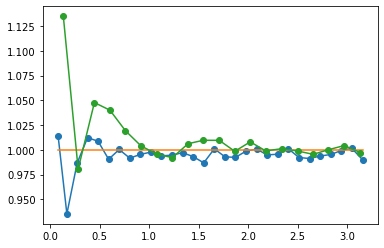

In [437]:
plt.plot(k, ps_1D_true, marker = 'o')
plt.plot(k,flat_ps(k))

plt.plot(k_from_2d, ps_from_2d_true,marker = 'o')

/var/folders/rx/h899l7s51ds34rqj_3lmczzh0000gn/T/ipykernel_25563/3532638830.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = plt.pcolor(k_perp,k_par,ps_2D_true, edgecolors='w', linewidth=0.5)


Text(0.5, 0, 'k$_{\\perp}[Mpc^{-1}]$')

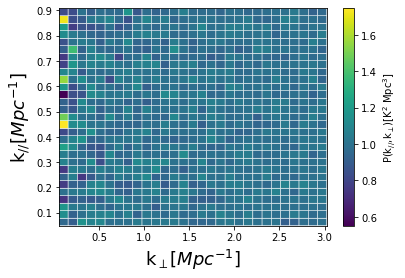

In [438]:
im = plt.pcolor(k_perp,k_par,ps_2D_true, edgecolors='w', linewidth=0.5)
plt.colorbar(label = 'P(k$_{//}$,k$_{\perp}$)[K$^2$ Mpc$^3$]') #worried about the scale, i think here you only need to divide by the 2d vol you're averaging over not the entire 3D vol. 
plt.ylabel('k$_{//}[Mpc^{-1}]$', fontsize = 18)
plt.xlabel('k$_{\perp}[Mpc^{-1}]$', fontsize = 18)


# plt.xscale('log')
# plt.yscale('log')

In [439]:
from scipy.interpolate import RectBivariateSpline

true_interp = RectBivariateSpline(k_par,k_perp, ps_2D_true, kx=1,ky = 1)



/var/folders/rx/h899l7s51ds34rqj_3lmczzh0000gn/T/ipykernel_25563/1023187881.py:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = plt.pcolor(kperp,kpar,true_interp(kpar,kperp), linewidth=0.5)


Text(0.5, 0, 'k$_{\\perp}[Mpc^{-1}]$')

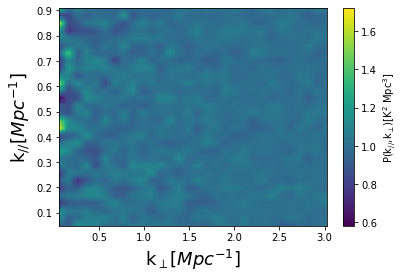

In [440]:
kperp = np.linspace(min(k_perp),max(k_perp),200)
kpar = np.linspace(min(k_par),max(k_par),200)


im = plt.pcolor(kperp,kpar,true_interp(kpar,kperp), linewidth=0.5)
plt.colorbar(label = 'P(k$_{//}$,k$_{\perp}$)[K$^2$ Mpc$^3$]') #worried about the scale, i think here you only need to divide by the 2d vol you're averaging over not the entire 3D vol. 
plt.ylabel('k$_{//}[Mpc^{-1}]$', fontsize = 18)
plt.xlabel('k$_{\perp}[Mpc^{-1}]$', fontsize = 18)


# plt.xscale('log')
# plt.yscale('log')

# Apply PSF

In [443]:
def Gaussian_2d(x,y,sigma_x,sigma_y,mu_x,mu_y):
    return np.exp(-((((x-mu_x)**2)/(2*(sigma_x**2))) + (((y-mu_y)**2)/(2*(sigma_y**2))))) * (1/(2*np.pi*sigma_x*sigma_y))

x = np.arange(-universe.npix/2,universe.npix/2,1)
y = np.arange(-universe.npix/2,universe.npix/2,1)
xx, yy = np.meshgrid(x,y, sparse = True)


mu = 0
sigma = 2
observed_box = np.zeros_like(box)
gaussian = np.reshape(Gaussian_2d(xx,yy,sigma,sigma,mu,mu),(universe.npix,universe.npix))
gauss_fft = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(gaussian)))




for i in range(universe.nfreqs):
    sky_fft = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(box[:,:,i])))
    # sky_fft = np.fft.fft2(box[:,:,i])

    
    product = sky_fft*gauss_fft
    new_sky = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(product)))

    # new_sky = np.fft.ifft2(product)
    observed_box[:,:,i] = np.real(new_sky)



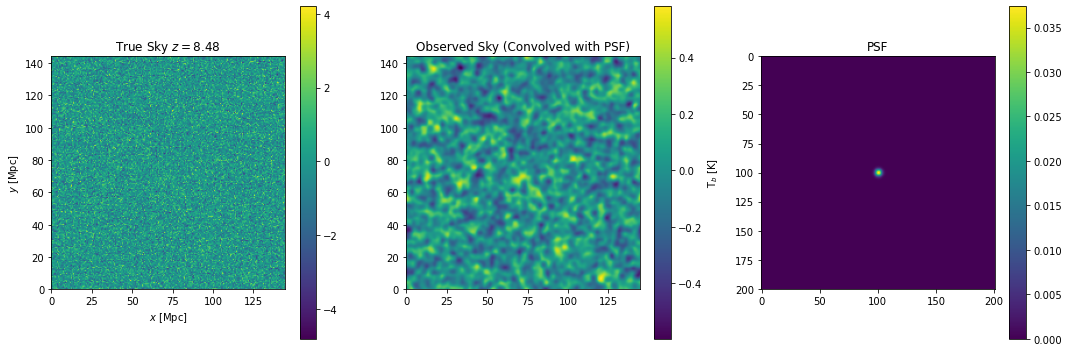

In [444]:
fig = plt.figure(figsize = (15,5))

plt.subplot(1, 3, 1)
plt.imshow(box[:, :, universe.nfreqs//2],
           origin='lower',
           extent=(0, universe.L, 0, universe.L))
plt.colorbar()
plt.xlabel(r'$x$ [Mpc]')
plt.ylabel(r'$y$ [Mpc]')
plt.title(fr'True Sky $z={universe.avg_z:.2f}$')


plt.subplot(1, 3, 2)
plt.imshow(observed_box[:,:,universe.nfreqs//2],
           origin='lower',
           extent=(0, universe.L, 0, universe.L))
plt.colorbar(label = 'T$_b$ [K]')
plt.title('Observed Sky (Convolved with PSF)')

plt.subplot(1, 3, 3)
plt.imshow(gaussian)
plt.colorbar()
plt.title('PSF')

plt.tight_layout()

# Pspec of Observed Cube

In [445]:
pspec_obs = power_spectrum.power_spectrum(data = observed_box * units.mK, 
                                          theta_x = fov, 
                                          theta_y= fov, 
                                          freqs =spw_window)
k_par, k_perp, ps_2D_obs = pspec_obs.compute_2D_pspec()
k_obs, ps_1D_obs = pspec_obs.compute_1D_pspec()

/Users/hannahfronenberg/Documents/GitHub/SKA_SDC3/ska_simulator/ska_simulator/power_spectrum.py:625: UserWarning: Assuming ps_data is in mK**2 Mpc3.
  ps_data = ps_data.value
/Users/hannahfronenberg/Documents/GitHub/SKA_SDC3/ska_simulator/ska_simulator/power_spectrum.py:829: UserWarning: Assuming ps_data is in mK**2 Mpc3.
  ps_data = ps_data.value


/var/folders/rx/h899l7s51ds34rqj_3lmczzh0000gn/T/ipykernel_25563/3115375023.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = plt.pcolor(k_perp,k_par,ps_2D_obs, edgecolors='w', linewidth=0.5)


Text(0.5, 0, 'k$_{\\perp}[Mpc^{-1}]$')

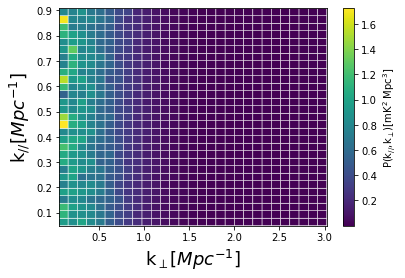

In [446]:



im = plt.pcolor(k_perp,k_par,ps_2D_obs, edgecolors='w', linewidth=0.5)
plt.colorbar(label = 'P(k$_{//}$,k$_{\perp}$)[mK$^2$ Mpc$^3$]') #worried about the scale, i think here you only need to divide by the 2d vol you're averaging over not the entire 3D vol. 
plt.ylabel('k$_{//}[Mpc^{-1}]$', fontsize = 18)
plt.xlabel('k$_{\perp}[Mpc^{-1}]$', fontsize = 18)


# plt.xscale('log')
# plt.yscale('log')

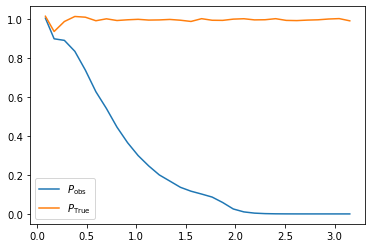

In [447]:
plt.plot(k_obs, ps_1D_obs, label = r'$P_{\rm{obs}}$')
plt.plot(k,ps_1D_true, label =r'$P_{\rm{True}}$')
plt.legend()

# plt.yscale('log')
# plt.xscale('log')

# Compute Window Funtion and $P_{\rm{obs}} = WP_{\rm{True}}$


TODO: Fix normalization of the window functions

In [416]:
PSF_stack = np.repeat(gaussian, universe.nfreqs)
PSF = np.reshape(PSF_stack,(universe.npix,universe.npix,universe.nfreqs))

In [417]:
window = window_function.window_function(PSF = PSF, 
                                        theta_x = fov,
                                        theta_y = fov,
                                        freqs = spw_window,
	)



In [418]:
FT_perp = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(PSF, axes = (0,1)), axes = (0,1)), axes = (0,1))
FT_perp *= (window.delta_x*window.delta_y) # dr_perp
BIG_FT_perp = np.reshape(FT_perp, (npix*npix,nfreqs))
FT_full= np.fft.fftshift(np.fft.fft(np.fft.ifftshift(BIG_FT_perp, axes = 1), axis = 1), axes = 1)
FT_full *= (window.delta_z) #dr_par



W = np.abs(FT_full)**2
## PUT IN VOLUME ELEMENT DO NOT FORGET 

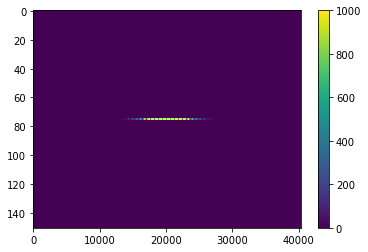

In [419]:
plt.imshow(np.real(W.T),vmax= 1000,aspect = 'auto')
# plt.xlim(19950,20050)
# plt.axvline(x = 20000)
plt.colorbar()

In [420]:
full_ps_true = pspec_true.FFT_crossxx()
full_ps_true = np.reshape(full_ps_true, (npix*npix,nfreqs))

In [421]:
### THE PROBLEM IS HERE!! AHA! 

W_FT = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(W, axes = 1), axis = 1), axes = 1)
full_ps_true_FT = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(full_ps_true, axes = 1), axis = 1), axes = 1)

WPtrue = W_FT*full_ps_true_FT

WPtrue *= (window.delta_k_par)/((2*np.pi)**3)
P_obs = np.fft.fftshift(np.fft.ifft(np.fft.ifftshift(WPtrue, axes = 1), axis = 1), axes = 1)


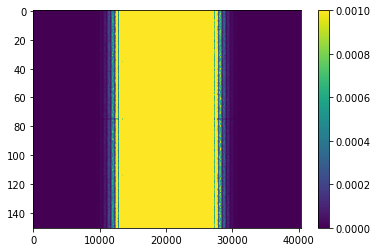

In [422]:
plt.imshow(np.real(P_obs.T),vmax = 0.001, aspect = 'auto')
# plt.xlim(19950,20050)
# plt.axvline(x = 20000)
plt.colorbar()

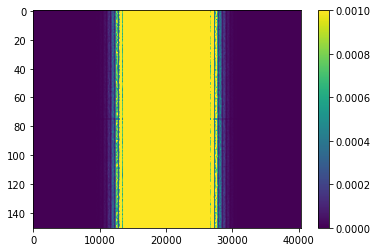

In [423]:
full_ps_obs = pspec_obs.FFT_crossxx()
full_ps_obs = np.reshape(full_ps_obs, (npix*npix,nfreqs))
plt.imshow(np.real(full_ps_obs.T),vmax = 0.001,aspect = 'auto')
plt.colorbar()



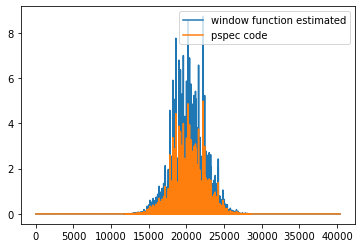

In [424]:
plt.plot(P_obs[:,100].real, label =  'window function estimated')
plt.plot(full_ps_obs[:,100].real, label = 'pspec code')
plt.legend()

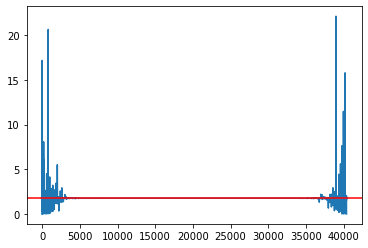

In [425]:
for sl in ( 70,):
    plt.plot(P_obs[:,sl].real/full_ps_obs[:,sl].real)
# plt.ylim(0,2)
plt.axhline(y = 1.74047047, color = 'r')
# plt.xlim(10000,30000)

In [426]:
np.mean((P_obs[13000:27000,70].real/full_ps_obs[13000:27000,70].real))

1.7520736320338224

In [357]:
np.mean((P_obs[13000:27000,70].real/full_ps_obs[13000:27000,70].real))

1.7404704968243694

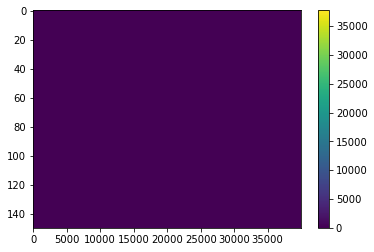

In [87]:
plt.imshow(np.real(full_ps_obs/P_obs).T,aspect = 'auto')
plt.colorbar()

In [251]:
FT_true = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(box, axes = (0,1)), axes = (0,1)), axes = (0,1))
BIG_FT_true = np.reshape(FT_true, (200*200,150))
x_obs = BIG_FT_perp*BIG_FT_true
x_obs *= window.delta_k_perp/(2*np.pi)**2

In [252]:
FT_obs = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(observed_box, axes = (0,1)), axes = (0,1)), axes = (0,1))
BIG_FT_obs = np.reshape(FT_obs, (200*
                                 200,150))
BIG_FT_obs *= (window.delta_x*window.delta_y) # dr_perp



/Users/hannahfronenberg/miniconda3/envs/py3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


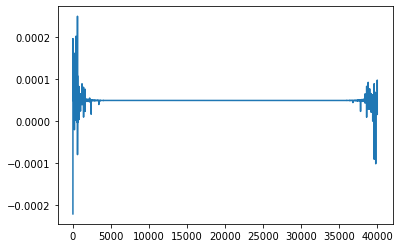

In [254]:
plt.plot(x_obs[:,1]/BIG_FT_obs[:,1])
# plt.ylim(0,2)


### 

In [42]:
pspec_for_window = power_spectrum.power_spectrum(data = box * units.mK, 
                                          theta_x = fov, 
                                          theta_y= fov , 
                                          freqs =spw_window,
                                          PSF = PSF)

window.load_pspec(pspec_for_window)

/var/folders/rx/h899l7s51ds34rqj_3lmczzh0000gn/T/ipykernel_17408/2329219397.py:1: UserWarning: Normalising PSF in-place.
  pspec_for_window = power_spectrum.power_spectrum(data = box * units.mK,
/Users/hannahfronenberg/Documents/GitHub/SKA_SDC3/ska_simulator/ska_simulator/window_function.py:55: UserWarning: Provided freqs does not have units. Assuming the input is provided in MHz.
  self.freqs = utils.comply_units(
/Users/hannahfronenberg/Documents/GitHub/SKA_SDC3/ska_simulator/ska_simulator/window_function.py:62: UserWarning: Provided rest_freq does not have units. Assuming the input is provided in MHz.
  self.rest_freq = utils.comply_units(
/Users/hannahfronenberg/Documents/GitHub/SKA_SDC3/ska_simulator/ska_simulator/window_function.py:74: UserWarning: Provided theta_x does not have units. Assuming the input is provided in rad.
  self.theta_x = utils.comply_units(
/Users/hannahfronenberg/Documents/GitHub/SKA_SDC3/ska_simulator/ska_simulator/window_function.py:80: UserWarning: Provide

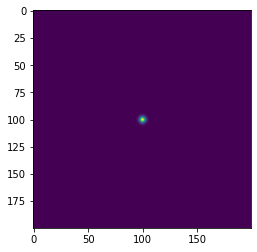

In [43]:
plt.imshow(window.PSF[:,:,1])

# Testing 3D window

as a first test, just make sure that M matrix of ones gives back input spectrum

### Identity Window Function

In [22]:
M= []

for i in range(npix_aisle):
    m = np.diag(np.diag(np.ones((50*50,50*50))))
    M.append(m)
    
M = np.asarray(M).T

### Gaussian Window Function 

In [23]:
def gauss(x,y,sigma_x,sigma_y,mu_x,mu_y):
    return np.exp(-((((x-mu_x)**2)/(2*(sigma_x**2))) + (((y-mu_y)**2)/(2*(sigma_y**2)))))#* (1/(2*np.pi*sigma_x*sigma_y))

x = np.arange(-25,25,1)
y = np.arange(-25,25,1)
xx, yy = np.meshgrid(x,y, sparse = True)


gaussian = np.reshape(gauss(xx,yy,1.5,1.5,0,0),(50,50)) 
M_gauss = np.zeros((2500,2500,50))
for i in range(npix_aisle):
    gaussian = np.reshape(gauss(xx,yy,1.5,1.5,0,0),(50,50))
    gaussian /=gaussian.sum()
    gaussian = gaussian.reshape(2500,)
    diag_g = np.diag(gaussian)
    M_gauss[:,:,i] = diag_g




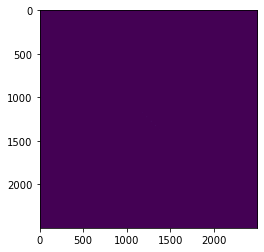

In [24]:
plt.imshow(M_gauss[:,:,2],interpolation= None)

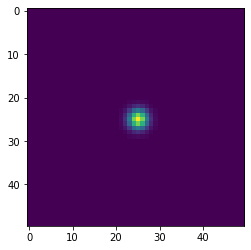

In [25]:
plt.imshow(np.reshape(np.diag(M_gauss[:,:,2]),(50,50)))

In [26]:
rest_freq = 1420
window = window_function_3D.Window_Function(M_gauss, npix_row, npix_col,theta_x,theta_y,freqs*(1e6),rest_freq*(1e6), nbins)



In [46]:
window.Lx, window.Ly,window.Lz, window.z_mid

(325.50000000000006, 325.50000000000006, 325.4979894550992, 8.000000000000002)

In [32]:
kmodes_true = np.fft.fftshift(pspec.k_par),pspec.k_perp_bin
kmodes_obs = np.fft.fftshift(pspec.k_par)

In [33]:
print(kmodes_true)

(array([-0.48258176, -0.46327849, -0.44397522, -0.42467195, -0.40536868,
       -0.38606541, -0.36676214, -0.34745887, -0.3281556 , -0.30885233,
       -0.28954906, -0.27024579, -0.25094252, -0.23163924, -0.21233597,
       -0.1930327 , -0.17372943, -0.15442616, -0.13512289, -0.11581962,
       -0.09651635, -0.07721308, -0.05790981, -0.03860654, -0.01930327,
        0.        ,  0.01930327,  0.03860654,  0.05790981,  0.07721308,
        0.09651635,  0.11581962,  0.13512289,  0.15442616,  0.17372943,
        0.1930327 ,  0.21233597,  0.23163924,  0.25094252,  0.27024579,
        0.28954906,  0.30885233,  0.3281556 ,  0.34745887,  0.36676214,
        0.38606541,  0.40536868,  0.42467195,  0.44397522,  0.46327849]), array([0.01137451, 0.02274902, 0.03412352, 0.04549803, 0.05687254,
       0.06824705, 0.07962156, 0.09099607, 0.10237057, 0.11374508,
       0.12511959, 0.1364941 , 0.14786861, 0.15924312, 0.17061762,
       0.18199213, 0.19336664, 0.20474115, 0.21611566, 0.22749017,
       0.

In [36]:
window.compute_2D_pspec_estimate(pspec.pspec_2D,kmodes_true,kmodes_obs)

perp FFT done
parallel FFT done
square done
sorted in k_perp


0.9
[1.38258176 1.36327849 1.34397522 1.32467195 1.30536868 1.28606541
 1.26676214 1.24745887 1.2281556  1.20885233 1.18954906 1.17024579
 1.15094252 1.13163924 1.11233597 1.0930327  1.07372943 1.05442616
 1.03512289 1.01581962 0.99651635 0.97721308 0.95790981 0.93860654
 0.91930327 0.9        0.88069673 0.86139346 0.84209019 0.82278692
 0.80348365 0.78418038 0.76487711 0.74557384 0.72627057 0.7069673
 0.68766403 0.66836076 0.64905748 0.62975421 0.61045094 0.59114767
 0.5718444  0.55254113 0.53323786 0.51393459 0.49463132 0.47532805
 0.45602478 0.43672151]


Text(0.5, 0, 'k$_{\\perp}[Mpc^{-1}]$')

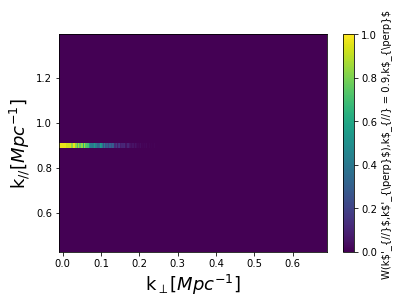

In [43]:
window.one_window()

plt.pcolor(window.k_perp_sorted,window.k_prime_sorted, window.window_to_plot.T,shading='auto')
plt.colorbar(label = 'W(k$\'_{//}$,k$\'_{\perp}$),k$_{//} = 0.9,k$_{\perp}$ ') #worried about the scale, i think here you only need to divide by the 2d vol you're averaging over not the entire 3D vol. 
plt.ylabel('k$_{//}[Mpc^{-1}]$', fontsize = 18)
plt.xlabel('k$_{\perp}[Mpc^{-1}]$', fontsize = 18)
# plt.title('Window Estimated Pspec')

Text(0.5, 1.0, 'Window Estimated Pspec')

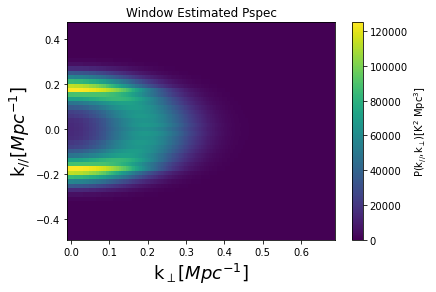

In [53]:
plt.pcolor(window.k_perp_sorted,kmodes_obs, window.p_estimate,shading='auto')
plt.colorbar(label = 'P(k$_{//}$,k$_{\perp}$)[K$^2$ Mpc$^3$]') #worried about the scale, i think here you only need to divide by the 2d vol you're averaging over not the entire 3D vol. 
plt.ylabel('k$_{//}[Mpc^{-1}]$', fontsize = 18)
plt.xlabel('k$_{\perp}[Mpc^{-1}]$', fontsize = 18)
plt.title('Window Estimated Pspec')

binned in k_perp


Text(0.5, 1.0, 'Winodw Estimated Pspec')

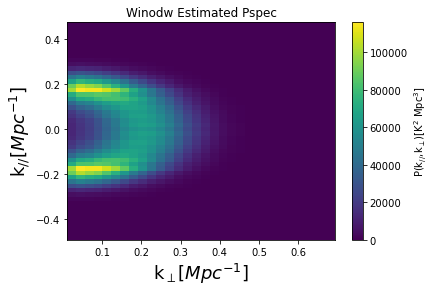

In [55]:
window.bin_p_estimate(pspec.pspec_2D,kmodes_true,kmodes_true)
im = plt.pcolor(pspec.k_perp_bin,kmodes_obs,window.p_estimate_binned, shading = 'auto')#edgecolors='w', linewidth=0.5)
plt.colorbar(label = 'P(k$_{//}$,k$_{\perp}$)[K$^2$ Mpc$^3$]') #worried about the scale, i think here you only need to divide by the 2d vol you're averaging over not the entire 3D vol. 
plt.ylabel('k$_{//}[Mpc^{-1}]$', fontsize = 18)
plt.xlabel('k$_{\perp}[Mpc^{-1}]$', fontsize = 18)
plt.title('Winodw Estimated Pspec')

Text(0.5, 1.0, 'Window Centered on')

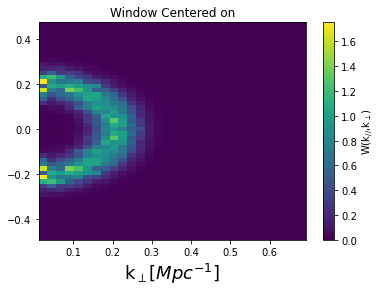

In [70]:

kmodes_true = np.fft.fftshift(pspec.k_par),pspec.k_perp_bin

window.interpolate_pspec_true(pspec.pspec_2D,kmodes_true)



plt.pcolor(kmodes_true[1],kmodes_obs,window.f(kmodes_true[0],kmodes_true[1]),shading='auto')
plt.colorbar(label = 'W(k$_{//}$,k$_{\perp}$)')
plt.xlabel('k$_{\perp}[Mpc^{-1}]$', fontsize = 18)
plt.title('Window Centered on')

Text(0.5, 1.0, 'True Pspec')

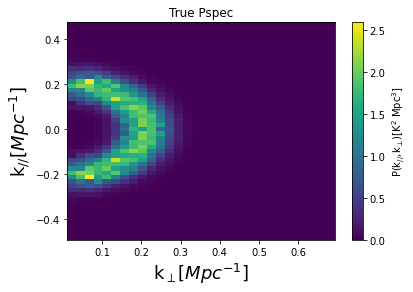

In [30]:
im = plt.pcolor(pspec.k_perp_bin,pspec.k_par,pspec.pspec_2D, shading = 'auto')#edgecolors='w', linewidth=0.5)
plt.colorbar(label = 'P(k$_{//}$,k$_{\perp}$)[K$^2$ Mpc$^3$]') #worried about the scale, i think here you only need to divide by the 2d vol you're averaging over not the entire 3D vol. 
plt.ylabel('k$_{//}[Mpc^{-1}]$', fontsize = 18)
plt.xlabel('k$_{\perp}[Mpc^{-1}]$', fontsize = 18)
plt.title('True Pspec')


In [ ]:
fig3 = plt.figure(figsize = (16,5),constrained_layout=False)
gs = fig3.add_gridspec(1, 3,hspace =0.2, wspace= 0.3)
ax1 = fig3.add_subplot(gs[0, 0])
ax2 = fig3.add_subplot(gs[0, 1])
ax3 = fig3.add_subplot(gs[0,2])

ax1.set_title('$M\mathcal{F}^{-1}\cdot \mathcal{F} x_{true}$', fontsize = 18, y = 1.01)
ax2.set_title(' $x_{true}$', fontsize = 18, y = 1.01 )
ax3.set_title('Residual', fontsize = 18, y = 1.01)

im1 = ax1.imshow(np.real((M_hat_x_hat)), aspect = 'auto')
im2 = ax2.imshow(np.reshape(uni_3d.universe,(2500,50)), aspect = 'auto')
im3 = ax3.imshow(np.real(M_hat_x_hat-np.reshape(uni_3d.universe,(2500,50))),aspect = 'auto')

cbar1 = fig3.colorbar(im1, ax=ax1)
cbar2 = fig3.colorbar(im2, ax=ax2)
cbar3 = fig3.colorbar(im3, ax=ax3)

# Check 1
M$\mathcal{F_\perp}^{-1}\cdot \mathcal{F_\perp} x_{true} = x_{true}$

In [169]:
window.compute_2D_FFT()

In [165]:

fft_uni_reshape = np.zeros((2500,50) ,dtype = complex)
for i in range(window.nfreqs):
    fft_uni = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(uni_3d.universe[:,:,i])))
    reshape = fft_uni.reshape((2500,))
    fft_uni_reshape[:,i] = reshape

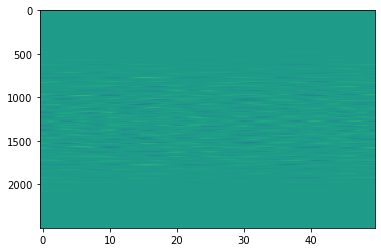

In [166]:
plt.imshow(np.real(fft_uni_reshape), aspect = 'auto')

In [147]:
window.Mbar.shape

(2500, 2500, 50)

In [170]:
M_hat_x_hat = np.zeros((window.Npix,window.nfreqs), dtype= complex)
for i in range(window.nfreqs):
    prod = window.Mbar[:,:,i].dot(fft_uni_reshape[:,i])
    M_hat_x_hat[:,i] = prod


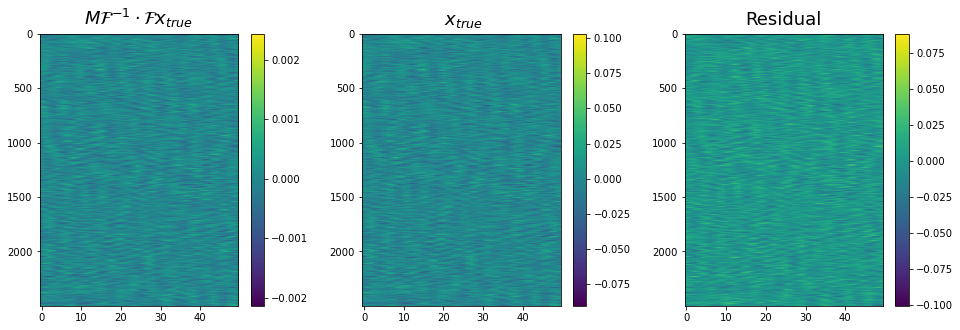

In [171]:
M_hat_x_hat = np.asarray(M_hat_x_hat)
fig3 = plt.figure(figsize = (16,5),constrained_layout=False)
gs = fig3.add_gridspec(1, 3,hspace =0.2, wspace= 0.3)
ax1 = fig3.add_subplot(gs[0, 0])
ax2 = fig3.add_subplot(gs[0, 1])
ax3 = fig3.add_subplot(gs[0,2])

ax1.set_title('$M\mathcal{F}^{-1}\cdot \mathcal{F} x_{true}$', fontsize = 18, y = 1.01)
ax2.set_title(' $x_{true}$', fontsize = 18, y = 1.01 )
ax3.set_title('Residual', fontsize = 18, y = 1.01)

im1 = ax1.imshow(np.real((M_hat_x_hat)), aspect = 'auto')
im2 = ax2.imshow(np.reshape(uni_3d.universe,(2500,50)), aspect = 'auto')
im3 = ax3.imshow(np.real(M_hat_x_hat-np.reshape(uni_3d.universe,(2500,50))),aspect = 'auto')

cbar1 = fig3.colorbar(im1, ax=ax1)
cbar2 = fig3.colorbar(im2, ax=ax2)
cbar3 = fig3.colorbar(im3, ax=ax3)

# right blobs! wrong amplitude. ok not bad 

# Check 2
$\mathcal{F_\perp}M\mathcal{F_\perp}^{-1}\cdot \mathcal{F_\perp} x_{true} = \mathcal{F_\perp}x_{obs}$

In [172]:
M_dhat_x_hat = np.zeros((window.Npix,window.nfreqs), dtype= complex)
for i in range(window.nfreqs):
    prod = window.M_tilde[:,:,i].dot(fft_uni_reshape[:,i])
    M_dhat_x_hat[:,i] = prod


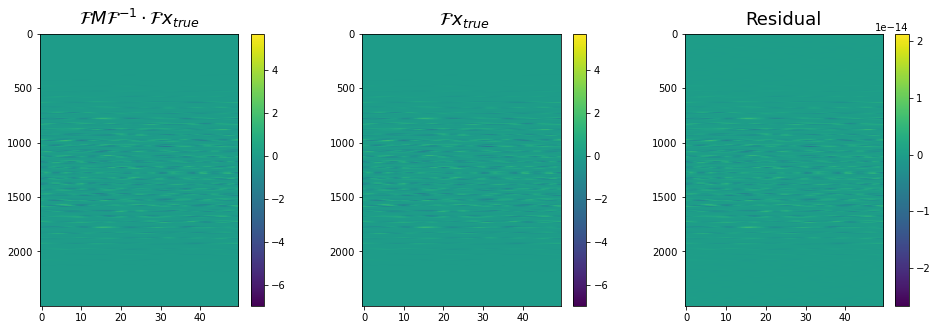

In [176]:
fig3 = plt.figure(figsize = (16,5),constrained_layout=False)
gs = fig3.add_gridspec(1, 3,hspace =0.2, wspace= 0.3)
ax1 = fig3.add_subplot(gs[0, 0])
ax2 = fig3.add_subplot(gs[0, 1])
ax3 = fig3.add_subplot(gs[0,2])

ax1.set_title('$\mathcal{F}M\mathcal{F}^{-1}\cdot \mathcal{F} x_{true}$', fontsize = 18, y = 1.01)
ax2.set_title(' $\mathcal{F}x_{true}$', fontsize = 18, y = 1.01 )
ax3.set_title('Residual', fontsize = 18, y = 1.01)

im1 = ax1.imshow(np.real(M_dhat_x_hat), aspect = 'auto')
im2 = ax2.imshow(np.real(fft_uni_reshape), aspect = 'auto')
im3 = ax3.imshow(np.real(M_dhat_x_hat-fft_uni_reshape),aspect = 'auto')

cbar1 = fig3.colorbar(im1, ax=ax1)
cbar2 = fig3.colorbar(im2, ax=ax2)
cbar3 = fig3.colorbar(im3, ax=ax3)



In [185]:
M_dhat_x_hat[1000,20], fft_uni_reshape[1000,20]

((1.2475321429621113e-06+6.077244089781291e-07j),
 (1.2475321428196588e-06+6.077244092590742e-07j))

# Check 3
$\mathcal{F_{\perp,\nu}}x_{true} = \sum_{k_{//}} \mathcal{F_\perp}\mathcal{F_{\nu}}M\mathcal{F_\perp}^{-1}\cdot \mathcal{F_\perp} x_{true} $

window.compute_freq_FFT()

In [26]:
window.compute_k_par()
window.k_perp , kmodes_obs

(array([0.6824705 , 0.66896035, 0.65574016, ..., 0.62846603, 0.64166746,
        0.65517168]),
 array([-0.48258176, -0.46327849, -0.44397522, -0.42467195, -0.40536868,
        -0.38606541, -0.36676214, -0.34745887, -0.3281556 , -0.30885233,
        -0.28954906, -0.27024579, -0.25094252, -0.23163924, -0.21233597,
        -0.1930327 , -0.17372943, -0.15442616, -0.13512289, -0.11581962,
        -0.09651635, -0.07721308, -0.05790981, -0.03860654, -0.01930327,
         0.        ,  0.01930327,  0.03860654,  0.05790981,  0.07721308,
         0.09651635,  0.11581962,  0.13512289,  0.15442616,  0.17372943,
         0.1930327 ,  0.21233597,  0.23163924,  0.25094252,  0.27024579,
         0.28954906,  0.30885233,  0.3281556 ,  0.34745887,  0.36676214,
         0.38606541,  0.40536868,  0.42467195,  0.44397522,  0.46327849]))

In [ ]:
f_x_obs = np.zeros((2500,50))

for i in range(len(kmodes_obs)):
    for j in range(len(window.k_par_minus_prime)):
        
        

In [32]:

fft_uni_3D_reshape = np.zeros((2500,50) ,dtype = complex)
fft_uni_3D = np.fft.fftshift(np.fft.fftn(np.fft.ifftshift(uni_3d.universe)))#*pspec.volume_element

for i in range(window.nfreqs):
    reshape = fft_uni_3D[:,:,i].reshape((2500,))
    fft_uni_3D_reshape[:,i] = reshape

In [192]:
#WRONG have to actually do the finding of the k and interpolate fft_uni_reshape

M_that_x_hat = np.zeros((window.Npix,window.nfreqs), dtype= complex)
for i in range(window.nfreqs):
    prod = window.full_Mtilde[:,:,i].dot(fft_uni_reshape[:,i])
    M_that_x_hat[:,i] = prod

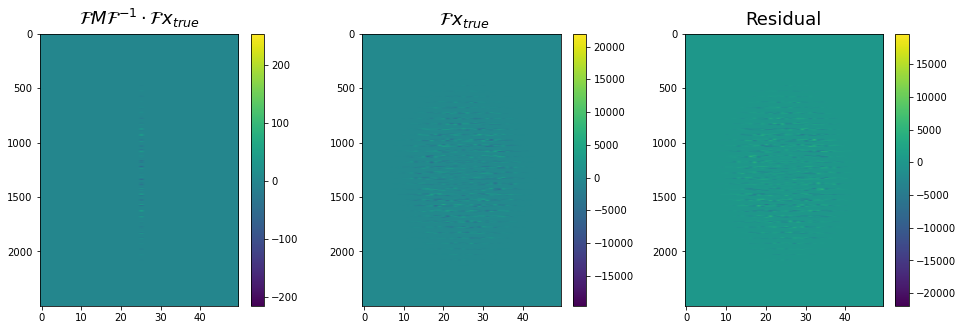

In [193]:
fig3 = plt.figure(figsize = (16,5),constrained_layout=False)
gs = fig3.add_gridspec(1, 3,hspace =0.2, wspace= 0.3)
ax1 = fig3.add_subplot(gs[0, 0])
ax2 = fig3.add_subplot(gs[0, 1])
ax3 = fig3.add_subplot(gs[0,2])

ax1.set_title('$\mathcal{F}M\mathcal{F}^{-1}\cdot \mathcal{F} x_{true}$', fontsize = 18, y = 1.01)
ax2.set_title(' $\mathcal{F}x_{true}$', fontsize = 18, y = 1.01 )
ax3.set_title('Residual', fontsize = 18, y = 1.01)

im1 = ax1.imshow(np.real(M_that_x_hat), aspect = 'auto')
im2 = ax2.imshow(np.real(fft_uni_3D_reshape), aspect = 'auto')
im3 = ax3.imshow(np.real(M_that_x_hat-fft_uni_3D_reshape),aspect = 'auto')

cbar1 = fig3.colorbar(im1, ax=ax1)
cbar2 = fig3.colorbar(im2, ax=ax2)
cbar3 = fig3.colorbar(im3, ax=ax3)

In [ ]:
# Fix primed coordinate, and plot the window function as a function of the unprimed coordinates. 
# 